# Setup

Install the dependencies:
```sh
pip install gym
pip install gym[atari]
```

# Useful Resources
* [Manual of the game](https://www.gamesdatabase.org/Media/SYSTEM/Atari_2600/Manual/formated/Freeway_-_1981_-_Zellers.pdf)
* [Freeway Disassembly](http://www.bjars.com/disassemblies.html)
* [Atari Ram Annotations](https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py)

# Description of the problem

TODO

# Imports

In [1]:
import sys
sys.path.append('../')  # Enable importing from `src` folder

In [2]:
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment

# Environment

We will be using the Open AI Gym framework in this study.......

In [3]:
# env, initial_state = environment.get_env()

# print("Action Space:", env.action_space)
# print("Observation Space:", env.observation_space)

The agent in this game has three possible actions:

* 0: Stay
* 1: Move forward
* 2: Move back

TODO: Talk a bit about the observation space of 128 bytes of RAM...

# Baseline

As a simple baseline, we are using an agent that moves always **up**.

In [4]:
# scores = environment.run(agents.Baseline, render=True, n_runs=1)

In [5]:
# Mean score
# print("Mean score:", sum(scores) / len(scores))

It usually scores from 21 to 23 points, as shown in the images below:

![Baseline 1](./img/baseline_1.png)
![Baseline 2](./img/baseline_2.png)

# Representing the state of the game

TODO: explain why we must reduce the state space

```
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    , 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
```

# Q-Learning

In [6]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [7]:
env, initial_state = environment.get_env()

In [8]:
agent = agents.QLearning(alpha=0.9, gamma=0.9, available_actions=2, N0=2.5)

In [9]:
scores = []
total_rewards = []

In [20]:
%%time

n_runs = 800

for i in range(n_runs):
    render = i % 101 == 0

    game_over = False
    state = env.reset()[RAM_mask].data.tobytes()  # Select useful bytes
    action = agent.act(state)  # TODO: aren't reducing the dimensionality
                               # of the *first* state, but it shouldn't
                               # impact the final result
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.005)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        # Doesn't matter where we were hit
        ob[16] = 1 if ob[16] != 255 else 0

        # Reduce chicken y-position
        ob[14] = ob[14] // 3

        # The chicken is in the x-posistion ~49
        # We don't need to represent cars far from the chicken
        for b in range(108, 118):
            if ob[b] < 20 or ob[b] > 80:
                ob[b] = 0
            else:
                # Reduce the cars x-positions sample space
                ob[b] = ob[b] // 3

        if reward == 1:
            score += 1
        elif ob[16] == 1:  # Collision!
            reward = -1
    #     elif reward != 1 and action != 1:  # Don't incentivate staying still
    #         reward -= 0.2

        total_reward += reward
    #     epi.add_step(state, action, reward, score)
        state = ob[RAM_mask].data.tobytes()

    #     Q[old_state][action] = Q[old_state][action] + alpha * (reward + gamma * Q[state].max() - Q[old_state][action])
        agent.update_Q(old_state, state, action, reward)

        action = agent.act(state)  # Next action




    scores.append(score)
    total_rewards.append(total_reward)

    print(f"Run [{i:3}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

Run [  0] - Total reward:   24.00 Mean scores: 20.77 Means Scores[:-10]: 22.90 Score: 24 
Run [  1] - Total reward:   24.00 Mean scores: 20.77 Means Scores[:-10]: 23.10 Score: 24 
Run [  2] - Total reward:   23.00 Mean scores: 20.77 Means Scores[:-10]: 22.90 Score: 23 
Run [  3] - Total reward:   22.00 Mean scores: 20.77 Means Scores[:-10]: 22.70 Score: 22 
Run [  4] - Total reward:   20.00 Mean scores: 20.77 Means Scores[:-10]: 22.50 Score: 20 
Run [  5] - Total reward:   23.00 Mean scores: 20.78 Means Scores[:-10]: 22.50 Score: 23 
Run [  6] - Total reward:   22.00 Mean scores: 20.78 Means Scores[:-10]: 22.60 Score: 22 
Run [  7] - Total reward:   23.00 Mean scores: 20.78 Means Scores[:-10]: 22.80 Score: 23 
Run [  8] - Total reward:   22.00 Mean scores: 20.78 Means Scores[:-10]: 22.60 Score: 22 
Run [  9] - Total reward:   22.00 Mean scores: 20.78 Means Scores[:-10]: 22.50 Score: 22 
Run [ 10] - Total reward:   24.00 Mean scores: 20.78 Means Scores[:-10]: 22.50 Score: 24 
Run [ 11] 

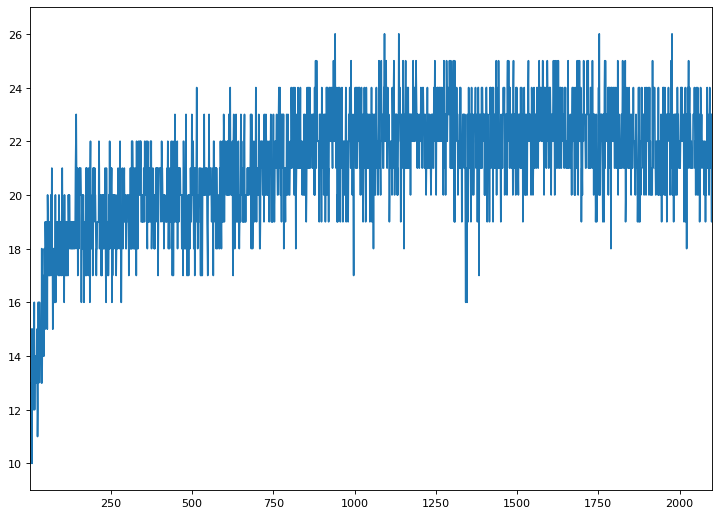

In [21]:
fig = plt.figure(figsize=(11, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0.9, len(scores) + 0.1)
ax.set_ylim(min(scores) - 1, max(scores) + 1)
ax.plot(range(1, len(scores) + 1), scores)
# ax.plot(range(1, len(scores) + 1), scores, 'bo')

In [ ]:
stop

After about 2100 iterations (without negative rewards):
```
Run [496] - Total reward:   22.00 Mean scores: 21.09 Means Scores[:-10]: 22.20 Score: 22 
Run [497] - Total reward:   21.00 Mean scores: 21.09 Means Scores[:-10]: 22.00 Score: 21 
Run [498] - Total reward:   19.00 Mean scores: 21.09 Means Scores[:-10]: 21.70 Score: 19 
Run [499] - Total reward:   23.00 Mean scores: 21.09 Means Scores[:-10]: 21.80 Score: 23 
```

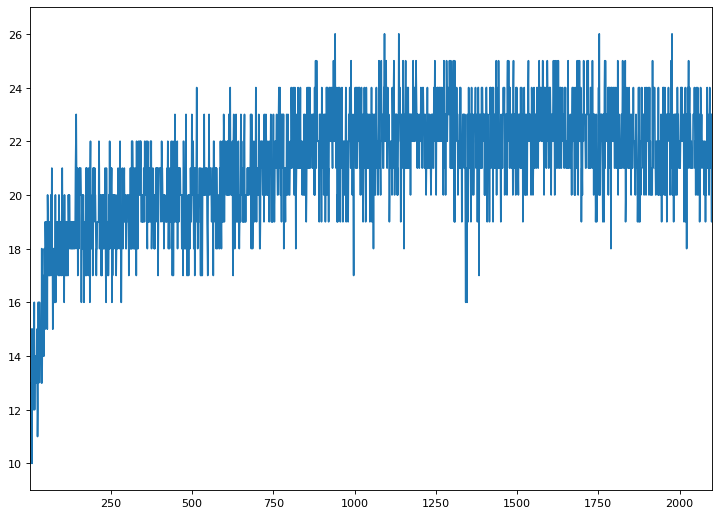

In [21]:
fig = plt.figure(figsize=(11, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0.9, len(scores) + 0.1)
ax.set_ylim(min(scores) - 1, max(scores) + 1)
ax.plot(range(1, len(scores) + 1), scores)
# ax.plot(range(1, len(scores) + 1), scores, 'bo')

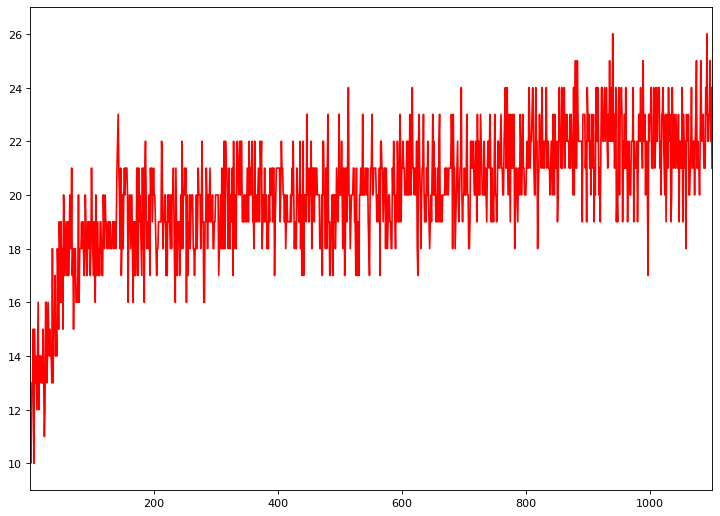

In [17]:
fig = plt.figure(figsize=(11, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0.9, len(total_rewards) + 0.1)
ax.set_ylim(min(total_rewards) - 1, max(scores) + 1)
ax.plot(range(1, len(total_rewards) + 1), total_rewards, color='red')
# ax.plot(range(1, len(total_rewards) + 1), total_rewards, 'ro')

In [11]:
stop

NameError: name 'stop' is not defined

# Monte Carlo Control

In [ ]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [ ]:
env, initial_state = environment.get_env()

In [ ]:
agent = agents.MonteCarloControl(gamma=0.95, available_actions=2, N0=0.5)

In [ ]:
def MonteCarloES(RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [ ]:
%%time
MonteCarloES(RAM_mask=RAM_mask, render=False)

In [ ]:
scores = []
total_rewards = []

In [ ]:
%%time

n_runs = 1000

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print(f"Run [{i:3}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / 10:5.2f} Score: {score:2} ")

### Visualizing the scores and rewards

In [ ]:
fig = plt.figure(figsize=(11, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0.9, len(scores) + 0.1)
ax.set_ylim(min(scores) - 1, max(scores) + 1)
ax.plot(range(1, len(scores) + 1), scores)
# ax.plot(range(1, len(scores) + 1), scores, 'bo')

In [ ]:
fig = plt.figure(figsize=(11, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0.9, len(total_rewards) + 0.1)
ax.set_ylim(min(total_rewards) - 1, max(scores) + 1)
ax.plot(range(1, len(total_rewards) + 1), total_rewards, color='red')
# ax.plot(range(1, len(total_rewards) + 1), total_rewards, 'ro')

In [ ]:
stop

## EDA - Counting unique values in the RAM of one round of the game

In [ ]:
states = np.array([e.state[RAM_POS_STATE] for e in episode])
states

In [ ]:
total_states = 1
for i, r in enumerate(states.T):
    total_states = len(np.unique(r)) * total_states
#     print(total_states)
    pass
print(total_states, len(str(total_states)))

In [ ]:
for i, r in enumerate(states.T):
#     print(f"[{i}]: {len(np.unique(r))} - {np.unique(r)}")
    pass